In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # Deep learning library
import tensorflow_addons as tfa # Additional libraries for TensorFlow
import matplotlib.pyplot as plt # Visualization

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale=1/255
)

train = image_data_generator.flow_from_directory(
    directory='../input/tomatoleaf/tomato/train', 
    class_mode='categorical',
    batch_size=32,
    target_size=(128, 128),
    color_mode='rgb',
    subset='training'
)

val = image_data_generator.flow_from_directory(
    directory='../input/tomatoleaf/tomato/train', 
    class_mode='categorical',
    batch_size=32,
    target_size=(128, 128),
    color_mode='rgb',
    subset='validation'
)

test = image_data_generator.flow_from_directory(
    directory='../input/tomatoleaf/tomato/val', 
    class_mode='categorical',
    batch_size=32,
    target_size=(128, 128),
    color_mode='rgb'
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [ ]:
def generate_convolution(i):
    conv2d = tf.keras.layers.Conv2D(
        2**(i+5), 
        (3, 3), 
        activation=tf.keras.activations.swish, 
        name=f'conv2d_{i+1}'
    )
    batchnorm = tf.keras.layers.BatchNormalization(name=f'batchnorm_{i+1}')
    maxpool2d = tf.keras.layers.MaxPool2D(2, 2, name=f'maxpool2d_{i+1}')
    return [conv2d, batchnorm, maxpool2d]

def generate_dense(i):
    dense = tf.keras.layers.Dense(2**(9-i), name=f'dense_{i+1}')
    dropout = tf.keras.layers.Dropout(0.5, name=f'dropout_{i+1}')
    return [dense, dropout]

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((128, 128, 3), name='input'),
    *[x for i in range(4) for x in generate_convolution(i)],
    tf.keras.layers.Flatten(name='flatten'),
    *[x for i in range(4) for x in generate_dense(i)],
    tf.keras.layers.Dense(10, activation='softmax', name='classifier')
], 'image_classifier')

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),
            tfa.metrics.F1Score(10, 'macro')],
    optimizer=tf.keras.optimizers.Adam(1e-3)
)

model.summary()

Model: "image_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 126, 126, 32)      128       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 61, 61, 64)        256       
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)  

In [ ]:
history = model.fit(
    train,
    epochs=50,
    validation_data=val,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, 
            restore_best_weights=True
        ), 
        tf.keras.callbacks.ReduceLROnPlateau(
            patience=2
        )
    ]
)

Epoch 1/50
250/250 [==============================] - 63s 241ms/step - loss: 51.2576 - categorical_accuracy: 0.2312 - f1_score: 0.2257 - val_loss: 65.9062 - val_categorical_accuracy: 0.1150 - val_f1_score: 0.0378
Epoch 2/50
250/250 [==============================] - 59s 238ms/step - loss: 22.2643 - categorical_accuracy: 0.3562 - f1_score: 0.3498 - val_loss: 36.8617 - val_categorical_accuracy: 0.1250 - val_f1_score: 0.0640
Epoch 3/50
250/250 [==============================] - 60s 240ms/step - loss: 11.0450 - categorical_accuracy: 0.4178 - f1_score: 0.4092 - val_loss: 10.0605 - val_categorical_accuracy: 0.3715 - val_f1_score: 0.3824
Epoch 4/50
250/250 [==============================] - 60s 239ms/step - loss: 5.8695 - categorical_accuracy: 0.4632 - f1_score: 0.4572 - val_loss: 1.8603 - val_categorical_accuracy: 0.6685 - val_f1_score: 0.6629
Epoch 5/50
250/250 [==============================] - 60s 239ms/step - loss: 3.3001 - categorical_accuracy: 0.5209 - f1_score: 0.5145 - val_loss: 3.98

In [ ]:
eval_result = model.evaluate(test)
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = tflite_converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(model_tflite)
    f.close()

32/32 [==============================] - 6s 187ms/step - loss: 0.2772 - categorical_accuracy: 0.9120 - f1_score: 0.9119


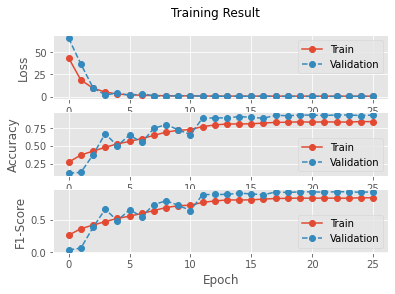

In [ ]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
fig.suptitle('Training Result')
ax1.plot(history.history['loss'], 'o-', label='Train')
ax1.plot(history.history['val_loss'], 'o--', label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(history.history['categorical_accuracy'], 'o-', label='Train')
ax2.plot(history.history['val_categorical_accuracy'], 'o--', label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax3.plot(history.history['f1_score'], 'o-', label='Train')
ax3.plot(history.history['val_f1_score'], 'o--', label='Validation')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-Score')
ax3.legend()
fig.show()